In [1]:
!pip install scikit-learn
!pip install matplotlib

In [2]:
import argparse
import glob
import json
import os
import shutil
from datetime import datetime as dt
from pathlib import Path
from typing import Union

from aind_data_schema.core.processing import (
    DataProcess,
    PipelineProcess,
    Processing,
    ProcessName,
)
from hdmf_zarr import NWBZarrIO

import utils.nwb_dict_utils as nwb_utils
from utils.preprocess import batch_processing

"""
This capsule should take in an NWB file, 
check the number of subjects (confirm this),
check the number of channels,
check the number of fibers,
then preprocess the arrays with the dF_F signal
"""


def write_output_metadata(
    metadata: dict,
    process_json_dir: str,
    process_name: str,
    input_fp: Union[str, Path],
    output_fp: Union[str, Path],
    start_date_time: dt,
) -> None:
    """Writes output metadata to plane processing.json

    Parameters
    ----------
    metadata: dict
        parameters passed to the capsule
    input_fp: str
        path to data input
    output_fp: str
        path to data output
    """
    with open(Path(process_json_dir) / "processing.json", "r") as f:
        proc_data = json.load(f)
    processing = Processing(
        processing_pipeline=PipelineProcess(
            processor_full_name="Fiberphotometry Processing Pipeline",
            pipeline_url=os.getenv("PIPELINE_URL", ""),
            pipeline_version=os.getenv("PIPELINE_VERSION", ""),
            data_processes=[
                DataProcess(
                    name=process_name,
                    software_version=os.getenv("VERSION", ""),
                    start_date_time=start_date_time,
                    end_date_time=dt.now(),
                    input_location=str(input_fp),
                    output_location=str(output_fp),
                    code_url=(os.getenv("DFF_EXTRACTION_URL")),
                    parameters=metadata,
                )
            ],
        )
    )
    prev_processing = Processing(**proc_data)
    prev_processing.processing_pipeline.data_processes.append(
        processing.processing_pipeline.data_processes[0]
    )
    prev_processing.write_standard_file(output_directory=Path(output_fp).parent)

In [3]:
start_time = dt.now()

# parser = argparse.ArgumentParser()
# parser.add_argument(
#     "--source_pattern",
#     type=str,
#     default=r"/data/nwb/*.nwb",
#     help="Source pattern to find nwb input files",
# )
# parser.add_argument(
#     "-o", "--output-dir", type=str, default="/results/", help="Output directory"
# )
# parser.add_argument(
#     "--fiber_path",
#     type=str,
#     default="/data/fiber_raw_data",
#     help="Directory of fiber raw data",
# )
# parser.add_argument(
#     '--dff_methods',
#     nargs='+',
#     default=["poly", "exp", "bright"],
#     help=(
#         "List of dff methods to run. Available options are:\n"
#         "  'poly': Fit with 4th order polynomial using ordinary least squares (OLS)\n"
#         "  'exp': Fit with biphasic exponential using OLS\n"
#         "  'bright': Robust fit with [Biphasic exponential decay (bleaching)] x "
#         "[Increasing saturating exponential (brightening)] using iteratively "
#         "reweighted least squares (IRLS)"
#     ),
# )
# args = parser.parse_args()

from types import SimpleNamespace
args = SimpleNamespace(
    source_pattern=r"/data/nwb/*.nwb",
    output_dir="/results/",
    fiber_path="/data/fiber_raw_data",
    dff_methods=["poly", "exp"]#, "bright"]
)


# Create the destination directory if it doesn't exist
os.makedirs(args.output_dir, exist_ok=True)

# Find all files matching the source pattern
source_paths = glob.glob(args.source_pattern)

In [4]:
# Copy each matching file to the destination directory
for source_path in source_paths:
    destination_path = os.path.join(
        args.output_dir, "nwb", os.path.basename(source_path)
    )
    shutil.copytree(source_path, destination_path)
    # Update path to the NWB file within the copied directory
    nwb_file_path = destination_path
    if os.path.isdir(os.path.join(args.fiber_path, "FIP")) or os.path.isdir(
        os.path.join(args.fiber_path, "fib")
    ):
        # Print the path to ensure correctness
        print(f"Processing NWB file: {nwb_file_path}")

        with NWBZarrIO(path=str(nwb_file_path), mode="r+") as io:
            nwb_file = io.read()
            # convert nwb to dataframe
            df_from_nwb = nwb_utils.nwb_to_dataframe(nwb_file)
            # add the session column
            filename = os.path.basename(nwb_file_path)
            if "behavior" in filename:
                session_name = filename.split(".")[0]
                session_name = session_name.split("behavior_")[1]
            else:
                session_name = filename.split(".")[0]
                session_name = session_name.split("FIP_")[1]

            df_from_nwb.insert(0, "session", session_name)

            # now pass the dataframe through the preprocessing function:
            df_fip_pp_nwb, df_PP_params, df_fip_mc = batch_processing(df_from_nwb, args.dff_methods)

            methods = df_fip_pp_nwb.preprocess.unique()
            for method in methods:
                for df, suffix in ((df_fip_pp_nwb, "dff"), (df_fip_mc, "preprocessed")):
                    # format the processed traces as dict to allow for proper conversion to nwb
                    dict_from_df = nwb_utils.split_fip_traces(
                        df[df.preprocess == method]
                    )
                    # and add them to the original nwb
                    nwb_file = nwb_utils.attach_dict_fip(nwb_file, dict_from_df, f"_{suffix}-{method}")

            io.write(nwb_file)
            print(
                f"Successfully updated the nwb with preprocessed data using methods {methods}"
            )
    else:
        print("NO Fiber but only Behavior data, preprocessing not needed")

Processing NWB file: /results/nwb/FIP_140_2024-06-24_01-49-46.nwb


/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.10/site-packages/statsmodels/robust/robust_linear_model.py:167: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
/opt/conda/lib/python3.10/site-packages/statsmodels/robust/robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/opt/conda/lib/python3.10/site-packages/statsmodels/robust/robust_linear_model.py:167: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
/opt/conda/lib/python3.10/site-packages/statsmodels/robust/robust_linea

Successfully updated the nwb with preprocessed data using methods ['poly' 'exp']


In [5]:
src_directory = args.fiber_path

# Iterate over all .json files in the source directory
if os.path.exists(src_directory):
    for filename in os.listdir(src_directory):
        if filename.endswith(".json") and filename!="processing.json":
            # Construct full file path
            src_file = os.path.join(src_directory, filename)
            dest_file = os.path.join(args.output_dir, filename)

            # Move the file
            shutil.copy2(src_file, dest_file)
            print(f"Moved: {src_file} to {dest_file}")

# Append to processing.json
write_output_metadata(
    vars(args),
    src_directory,
    ProcessName.DF_F_ESTIMATION,
    source_path,
    os.path.join(args.output_dir, "nwb"),
    start_time,
)

In [6]:
with NWBZarrIO(path=str(nwb_file_path), mode="r+") as io:
    nwb_file = io.read()
nwb_file

root pynwb.file.NWBFile at 0x140612544840656
Fields:
  acquisition: {
    G_1 <class 'pynwb.base.TimeSeries'>,
    G_1_dff-exp <class 'pynwb.base.TimeSeries'>,
    G_1_dff-poly <class 'pynwb.base.TimeSeries'>,
    G_1_preprocessed-exp <class 'pynwb.base.TimeSeries'>,
    G_1_preprocessed-poly <class 'pynwb.base.TimeSeries'>,
    G_2 <class 'pynwb.base.TimeSeries'>,
    G_2_dff-exp <class 'pynwb.base.TimeSeries'>,
    G_2_dff-poly <class 'pynwb.base.TimeSeries'>,
    G_2_preprocessed-exp <class 'pynwb.base.TimeSeries'>,
    G_2_preprocessed-poly <class 'pynwb.base.TimeSeries'>,
    Iso_1 <class 'pynwb.base.TimeSeries'>,
    Iso_1_dff-exp <class 'pynwb.base.TimeSeries'>,
    Iso_1_dff-poly <class 'pynwb.base.TimeSeries'>,
    Iso_1_preprocessed-exp <class 'pynwb.base.TimeSeries'>,
    Iso_1_preprocessed-poly <class 'pynwb.base.TimeSeries'>,
    Iso_2 <class 'pynwb.base.TimeSeries'>,
    Iso_2_dff-exp <class 'pynwb.base.TimeSeries'>,
    Iso_2_dff-poly <class 'pynwb.base.TimeSeries'>,
    Iso_2_preprocessed-exp <class 'pynwb.base.TimeSeries'>,
    Iso_2_preprocessed-poly <class 'pynwb.base.TimeSeries'>,
    R_1 <class 'pynwb.base.TimeSeries'>,
    R_1_dff-exp <class 'pynwb.base.TimeSeries'>,
    R_1_dff-poly <class 'pynwb.base.TimeSeries'>,
    R_1_preprocessed-exp <class 'pynwb.base.TimeSeries'>,
    R_1_preprocessed-poly <class 'pynwb.base.TimeSeries'>,
    R_2 <class 'pynwb.base.TimeSeries'>,
    R_2_dff-exp <class 'pynwb.base.TimeSeries'>,
    R_2_dff-poly <class 'pynwb.base.TimeSeries'>,
    R_2_preprocessed-exp <class 'pynwb.base.TimeSeries'>,
    R_2_preprocessed-poly <class 'pynwb.base.TimeSeries'>
  }
  file_create_date: [datetime.datetime(2024, 8, 5, 18, 28, 20, 845801, tzinfo=tzutc())]
  identifier: e8633480-ddb4-4900-bf4c-facb58fc01af
  institution: Allen Institute for Neural Dynamics
  session_description: NWB file generated by AIND pipeline
  session_id: FIP_140_2024-06-24_01-49-46
  session_start_time: 2024-06-24 01:49:46.290788-07:00
  subject: subject pynwb.file.Subject at 0x140612544840224
Fields:
  age: P50D
  age__reference: birth
  description: this is a mock mouse.
  sex: F
  subject_id: subject

  timestamps_reference_time: 2024-06-24 01:49:46.290788-07:00

In [7]:
import matplotlib.pyplot as plt

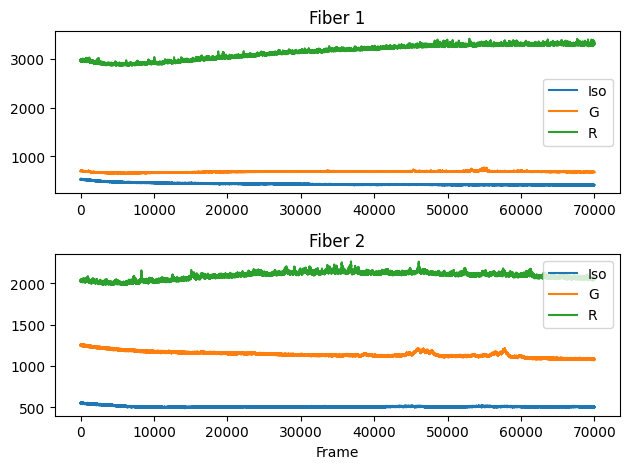

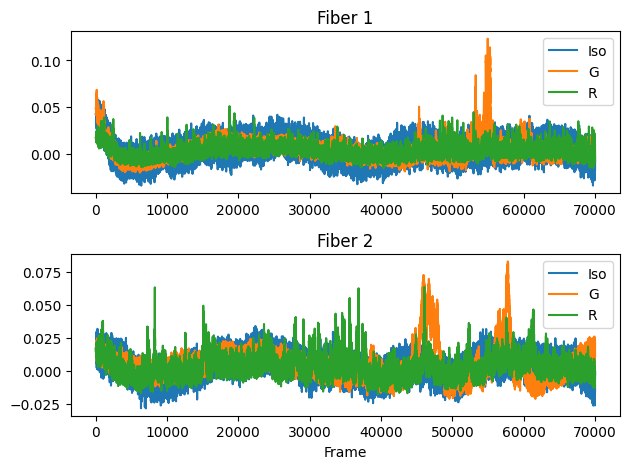

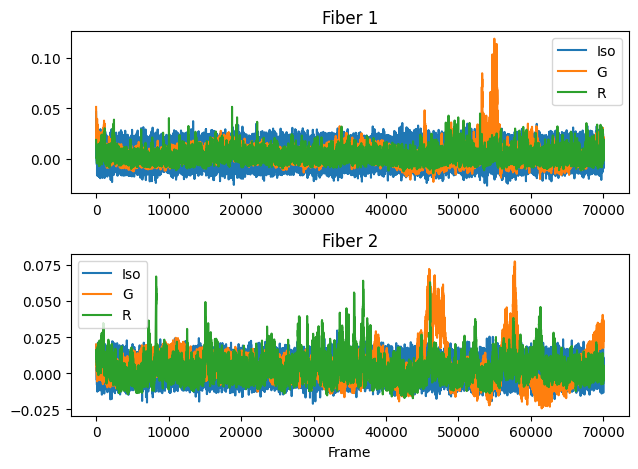

In [8]:
for suffix in ("", "_dff-poly", "_preprocessed-poly"):
    plt.figure()
    for fiber in (1,2):
        plt.subplot(2,1,fiber)
        for k in ("Iso", "G", "R"):
            d = nwb_file.acquisition[k + f"_{fiber}{suffix}"].data[:]
            plt.plot(d, label=k)
        plt.legend()
        plt.title(f"Fiber {fiber}")
    plt.xlabel("Frame")
    plt.tight_layout()